In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi
import scipy.interpolate as sci

import os 
import json

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl
import cbmos.utils as ut
import cbmos.events as ev

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

from matplotlib import cm
import matplotlib.colors as mcolors

In [2]:
import scipy
scipy.__version__

'1.5.4'

In [3]:
s = 1.0
rA = 1.5
params_cubic = {'mu': 5.7, 's': s, 'rA': rA}
dim = 3
seed = 67
tf = 1500.0 # in order to reach 1000 cells (starting at 512)
frequency = 1.0

In [4]:
#algorithms
#algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap', 'fixed_dt']


models = {'EF_glob_adap_acc': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
          'EF_glob_adap_stab': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),  
          'EF_local_adap': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim), 
          'EB_global_adap': cbmos.CBModel(ff.Cubic(), eb.solve_ivp, dim) }

eta = 1e-4
eps = 0.005

params = {'EF_glob_adap_acc': {'eps': eps, 'eta': eta},
          'EF_glob_adap_stab': {'eps': eps, 'eta': eta, 
                                'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 
                                'always_calculate_Jacobian': True, 
                                #'calculate_eigenvalues': True
                               }, 
          'EF_local_adap': {'eps': eps, 'eta': eta, 
                            'jacobian': models['EF_local_adap'].jacobian, 'force_args': params_cubic, 
                            'always_calculate_Jacobian': True, 
                            'local_adaptivity': True, 'm0': 14, 
                            #'calculate_eigenvalues': True
                            #'dim': dim, 
                            'rA': rA 
                           }, 
          'EB_global_adap': {'eps': eps, 'eta': eta, 'jacobian': models['EB_global_adap'].jacobian, 'force_args': params_cubic}
         }


labels = {'EF_glob_adap_acc': 'Alg. I (SRFE)', 
          'EF_glob_adap_stab': 'Alg. II (SRFES)' ,  
          'EF_local_adap': 'Alg. III (MRFE)', 
          'EB_global_adap': 'Alg. IV (SRBE)',
          'fixed_dt': 'dt fixed'
         }
defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'EF_glob_adap_acc': defcolors[0], 
          'EF_glob_adap_stab': defcolors[1] ,  
          'EF_local_adap': defcolors[2], 
          'EB_global_adap': defcolors[3], 
          'fixed_dt' : defcolors[5]}

In [5]:
dates = {0.1: '20220506', 0.5: '20220507', 1.0: '20220507', 2.0:'20220506'}
times_between_divisions = [0.1, 0.5, 1.0, 2.0]
base_sizes = [13, 14, 15, 16]
#base_sizes = [13]

In [6]:
alg = 'fixed_dt'
data_fixed_dt = {}
for size in base_sizes:
    times = []
    for tbe in [0.1, 0.5, 1.0, 2.0]:
        if tbe == 2.0 and size != 13:
            continue
        # handle size=16, tbe=1.0 individually
        if size==16 and tbe == 1.0:
            day = '20220509'
        else:
            day = dates[tbe]        
        with open('data/'+day+'_rackham_'+str(size)+'_'+str(tbe)+'_'+alg+'.json', 'r') as f:
            wall_time = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
        times.append(wall_time) 
    data_fixed_dt[size] = times
    

In [7]:
data_fixed_dt

{13: [86.68667089939117,
  422.953333735466,
  892.1566143631935,
  1643.7156115174294],
 14: [124.47029334306717, 613.3651329278946, 1249.2150719165802],
 15: [187.736481487751, 909.0834839940071, 1866.6468936800957],
 16: [278.008152782917, 1349.483847439289, 2788.3237709999084]}

In [8]:
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap' ]
data = {}
for alg in algorithms:
    data[alg] = {}
    for size in base_sizes:
        times = []
        for tbe in times_between_divisions:
            if tbe == 2.0 and size != 13:
                continue
            # handle size=16, tbe=1.0 individually for EF_glob_adap_stab
            if alg=='EF_glob_adap_stab' and size==16 and tbe == 1.0:
                day = '20220509'
            else:
                day = dates[tbe] 
            with open('data/'+day+'_rackham_'+str(size)+'_'+str(tbe)+'_'+alg+'.json', 'r') as f:
                wall_time = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
            if size == 13:
                print(alg+', '+str(tbe)+': '+str(wall_time))
            times.append(wall_time) 
        data[alg][size] = list(np.array(times)/np.array(data_fixed_dt[size]))

EF_glob_adap_acc, 0.1: 83.58195924758911
EF_glob_adap_acc, 0.5: 139.06763410568237
EF_glob_adap_acc, 1.0: 167.11462724208832
EF_glob_adap_acc, 2.0: 235.33132594823837
EF_glob_adap_stab, 0.1: 216.3360750079155
EF_glob_adap_stab, 0.5: 442.9266610145569
EF_glob_adap_stab, 1.0: 704.3915808200836
EF_glob_adap_stab, 2.0: 1013.7634478807449
EF_local_adap, 0.1: 106.7688398361206
EF_local_adap, 0.5: 332.4275848865509
EF_local_adap, 1.0: 601.0789261460304
EF_local_adap, 2.0: 1098.3443470597267


In [9]:
alg = 'EB_global_adap'
data[alg] = {}
for size in [13, 14]:
    times = []
    for tbe in times_between_divisions:
        if tbe == 2.0 and size != 13:
            continue
        with open('data/'+dates[tbe]+'_rackham_'+str(size)+'_'+str(tbe)+'_'+alg+'.json', 'r') as f:
            wall_time = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
        if size == 13:
            print(alg+', '+str(tbe)+': '+str(wall_time))
        times.append(wall_time) 
    data[alg][size] = list(np.array(times)/np.array(data_fixed_dt[size]))

EB_global_adap, 0.1: 551.6300373673439
EB_global_adap, 0.5: 966.5549150705338
EB_global_adap, 1.0: 1273.6276148557663
EB_global_adap, 2.0: 1464.6658571362495


In [10]:
data

{'EF_glob_adap_acc': {13: [0.9641846708428173,
   0.3288013665182777,
   0.1873153486188879,
   0.1431703418153871],
  14: [1.0450574544586881, 0.3389746831877794, 0.20213706633710782],
  15: [1.0615356446165873, 0.3398716513937967, 0.2154830000037592],
  16: [1.0123715565372124, 0.32372191832220415, 0.20699304713699587]},
 'EF_glob_adap_stab': {13: [2.4956094491043017,
   1.047223477594299,
   0.7895380356764676,
   0.6167511221389865],
  14: [2.704197626791903, 1.0961662610393141, 0.8318388867268623],
  15: [2.7432038608991873, 1.086687935222492, 0.8990327727018576],
  16: [2.6274656504651763, 1.1160183200832936, 0.9041357008031591]},
 'EF_local_adap': {13: [1.2316638616799214,
   0.7859675249526843,
   0.6737370058900146,
   0.668208258997898],
  14: [1.3344841976489825, 0.8294491112598826, 0.7428975218829682],
  15: [1.3264622610895362, 0.7903835313092578, 0.755650597893389],
  16: [1.4177518775309674, 0.8831226804880443, 0.7828474574015449]},
 'EB_global_adap': {13: [6.36349316041

In [11]:
# add data for size = 13, tbe = 5.0
alg = 'fixed_dt'
size = 13
tbe = 5.0
day = '20220509'
with open('data/'+day+'_rackham_'+str(size)+'_'+str(tbe)+'_'+alg+'.json', 'r') as f:
    wall_time = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
data_fixed_dt[size].append(wall_time)

algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap' ]
for alg in algorithms:
    # handle individually for EF_local_adap
    if alg=='EF_local_adap':
        day = '20220509'
    else:
        day = '20220506' 
    with open('data/'+day+'_rackham_'+str(size)+'_'+str(tbe)+'_'+alg+'.json', 'r') as f:
        wall_time = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
    print(alg+', '+str(tbe)+': '+str(wall_time))
    data[alg][size].append(wall_time/data_fixed_dt[size][-1])
    
alg = 'EB_global_adap'
day = '20220506'
with open('data/'+day+'_rackham_'+str(size)+'_'+str(tbe)+'_'+alg+'.json', 'r') as f:
    wall_time = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
print(alg+', '+str(tbe)+': '+str(wall_time))
data[alg][size].append(wall_time/data_fixed_dt[size][-1])

EF_glob_adap_acc, 5.0: 534.815206348896
EF_glob_adap_stab, 5.0: 1340.9051216244698
EF_local_adap, 5.0: 2826.7440151572227
EB_global_adap, 5.0: 2016.2674244642258


In [12]:
data_fixed_dt

{13: [86.68667089939117,
  422.953333735466,
  892.1566143631935,
  1643.7156115174294,
  4498.7798464894295],
 14: [124.47029334306717, 613.3651329278946, 1249.2150719165802],
 15: [187.736481487751, 909.0834839940071, 1866.6468936800957],
 16: [278.008152782917, 1349.483847439289, 2788.3237709999084]}

In [13]:
data

{'EF_glob_adap_acc': {13: [0.9641846708428173,
   0.3288013665182777,
   0.1873153486188879,
   0.1431703418153871,
   0.11888005739294685],
  14: [1.0450574544586881, 0.3389746831877794, 0.20213706633710782],
  15: [1.0615356446165873, 0.3398716513937967, 0.2154830000037592],
  16: [1.0123715565372124, 0.32372191832220415, 0.20699304713699587]},
 'EF_glob_adap_stab': {13: [2.4956094491043017,
   1.047223477594299,
   0.7895380356764676,
   0.6167511221389865,
   0.2980597333898945],
  14: [2.704197626791903, 1.0961662610393141, 0.8318388867268623],
  15: [2.7432038608991873, 1.086687935222492, 0.8990327727018576],
  16: [2.6274656504651763, 1.1160183200832936, 0.9041357008031591]},
 'EF_local_adap': {13: [1.2316638616799214,
   0.7859675249526843,
   0.6737370058900146,
   0.668208258997898,
   0.6283357069279661],
  14: [1.3344841976489825, 0.8294491112598826, 0.7428975218829682],
  15: [1.3264622610895362, 0.7903835313092578, 0.755650597893389],
  16: [1.4177518775309674, 0.88312268

In [14]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=defcolors[0], lw=3),
                Line2D([0], [0], color=defcolors[1], lw=3),
                Line2D([0], [0], color=defcolors[2], lw=3),
                Line2D([0], [0], color=defcolors[3], lw=3)]

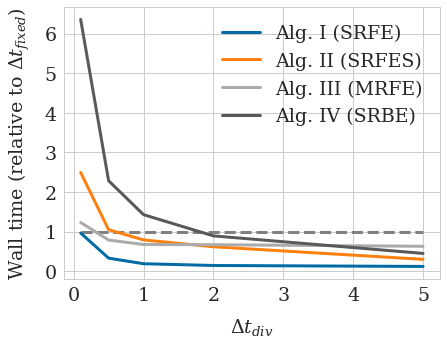

In [15]:
plt.plot([0.1, 0.5, 1.0, 5.0], np.ones(len([0.1, 0.5, 1.0, 5.0])), '--', color='grey')
for alg in algorithms:
    size = 13
    plt.plot([0.1, 0.5, 1.0, 2.0, 5.0], data[alg][size], color=colors[alg])
#    size = 16
#    plt.plot([0.1, 0.5, 1.0], data[alg][size], color=colors[alg], linestyle=':')
alg = 'EB_global_adap'
for size in [13]:
    plt.plot([0.1, 0.5, 1.0, 2.0, 5.0], data[alg][size], color=colors[alg])
plt.xlabel('$\Delta t_{div}$')
plt.ylabel('Wall time (relative to $\Delta t_{fixed}$)')
plt.legend(custom_lines, [labels['EF_glob_adap_acc'], labels['EF_glob_adap_stab'] ,  labels['EF_local_adap'], labels['EB_global_adap'] ])

plt.savefig('linear_tissue_growth_relative_wall_time.pdf', bbox_inches='tight')